In [ ]:
!pip install torch transformers easyocr pillow soundfile scipy numpy opencv-python-headless accelerate sentencepiece

In [1]:
import os
import sys
import torch
import easyocr
import numpy as np
import cv2
import re
import soundfile as sf
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, VitsModel, AutoTokenizer
from IPython.display import Audio, display, Image as IPImage

# Configuración
BASE_DIR = os.getcwd()
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

TROCR_MODEL_NAME = "microsoft/trocr-base-handwritten"
TTS_MODEL_NAME = "facebook/mms-tts-spa"
SAMPLE_RATE = 16000

print("Configuración lista.")
print(f"Dispositivo: {'cuda' if torch.cuda.is_available() else 'cpu'}")

c:\Users\Administrator\Desktop\integrado\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuración lista.
Dispositivo: cpu


In [2]:
class TextDetector:
    def __init__(self):
        print("Cargando modelo de detección (EasyOCR)...")
        self.reader = easyocr.Reader(['es'], gpu=torch.cuda.is_available()) 

    def detect_lines(self, image_path):
        print(f"Detectando texto en: {image_path}")
        results = self.reader.readtext(image_path)
        # Ordenar por posición vertical
        results.sort(key=lambda x: x[0][0][1]) 

        image = Image.open(image_path).convert("RGB")
        crops = []
        
        for (bbox, text, prob) in results:
            (tl, tr, br, bl) = bbox
            x_min = int(min(tl[0], bl[0]))
            x_max = int(max(tr[0], br[0]))
            y_min = int(min(tl[1], tr[1]))
            y_max = int(max(bl[1], br[1]))
            
            padding = 5
            x_min = max(0, x_min - padding)
            y_min = max(0, y_min - padding)
            x_max = min(image.width, x_max + padding)
            y_max = min(image.height, y_max + padding)
            
            crop = image.crop((x_min, y_min, x_max, y_max))
            crops.append(crop)
            
        return crops

In [3]:
class TextRecognizer:
    def __init__(self):
        print(f"Cargando modelo de reconocimiento ({TROCR_MODEL_NAME})...")
        self.processor = TrOCRProcessor.from_pretrained(TROCR_MODEL_NAME)
        self.model = VisionEncoderDecoderModel.from_pretrained(TROCR_MODEL_NAME)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def recognize_image(self, image: Image.Image):
        pixel_values = self.processor(images=image, return_tensors="pt").pixel_values.to(self.device)
        generated_ids = self.model.generate(pixel_values)
        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return generated_text

In [4]:
class TextPostProcessor:
    def clean_text(self, text):
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def process_batch(self, text_list):
        full_text = " ".join([self.clean_text(t) for t in text_list])
        return full_text

In [5]:
class VoiceSynthesizer:
    def __init__(self):
        print(f"Cargando modelo de voz ({TTS_MODEL_NAME})...")
        self.tokenizer = AutoTokenizer.from_pretrained(TTS_MODEL_NAME)
        self.model = VitsModel.from_pretrained(TTS_MODEL_NAME)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def synthesize(self, text, output_path):
        print(f"Sintetizando audio para: '{text[:50]}...'")
        inputs = self.tokenizer(text, return_tensors="pt")
        inputs = inputs.to(self.device)

        with torch.no_grad():
            output = self.model(**inputs).waveform

        waveform = output.cpu().float().numpy()[0]
        sf.write(output_path, waveform, self.model.config.sampling_rate)
        print(f"Audio guardado en: {output_path}")
        return output_path

In [6]:
def run_pipeline(image_filename):
    image_path = os.path.join(INPUT_DIR, image_filename)
    if not os.path.exists(image_path):
        print(f"Error: No se encontró {image_path}")
        return

    # Mostrar imagen original
    print(f"Procesando: {image_filename}")
    display(IPImage(filename=image_path, width=400))

    # 1. Detección
    detector = TextDetector()
    crops = detector.detect_lines(image_path)
    
    if not crops:
        print("No se detectó texto.")
        return

    # 2. Reconocimiento
    recognizer = TextRecognizer()
    recognized_lines = []
    print("\n--- Reconocimiento ---")
    for i, crop in enumerate(crops):
        text = recognizer.recognize_image(crop)
        print(f"Línea {i+1}: {text}")
        recognized_lines.append(text)

    # 3. Procesamiento
    processor = TextPostProcessor()
    full_text = processor.process_batch(recognized_lines)
    print(f"\n--- Texto Final ---\n{full_text}\n")

    # 4. Síntesis
    synthesizer = VoiceSynthesizer()
    output_filename = os.path.splitext(image_filename)[0] + ".wav"
    output_path = os.path.join(OUTPUT_DIR, output_filename)
    
    synthesizer.synthesize(full_text, output_path)
    
    # Reproducir audio
    print("\n--- Audio Generado ---")
    display(Audio(output_path))

Imágenes disponibles en input/:
 - unnamed.png
Procesando: unnamed.png


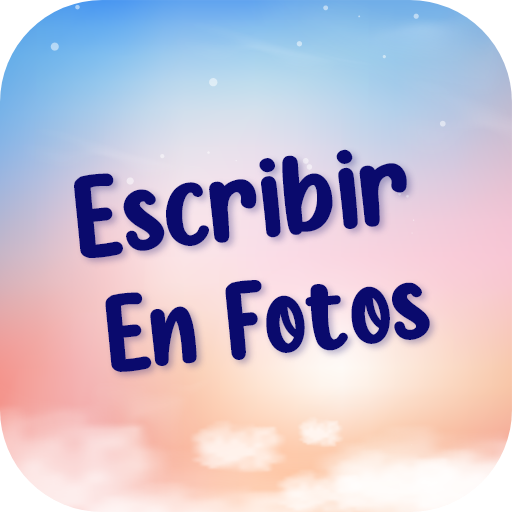

Using CPU. Note: This module is much faster with a GPU.


Cargando modelo de detección (EasyOCR)...
Detectando texto en: c:\Users\Administrator\Desktop\integrado\handwriting_tts\input\unnamed.png


c:\Users\Administrator\Desktop\integrado\.venv\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Cargando modelo de reconocimiento (microsoft/trocr-base-handwritten)...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Reconocimiento ---
Línea 1: escribir .
Línea 2: En Fotos .

--- Texto Final ---
escribir . En Fotos .

Cargando modelo de voz (facebook/mms-tts-spa)...
Sintetizando audio para: 'escribir . En Fotos ....'
Audio guardado en: c:\Users\Administrator\Desktop\integrado\handwriting_tts\output\unnamed.wav

--- Audio Generado ---


In [7]:
# Listar imágenes disponibles
print("Imágenes disponibles en input/:")
images = []
if os.path.exists(INPUT_DIR):
    for f in os.listdir(INPUT_DIR):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f" - {f}")
            images.append(f)
else:
    print("La carpeta input/ no existe o está vacía.")

# Ejecutar pipeline con la primera imagen encontrada si existe
if images:
    # Cambia 'images[0]' por el nombre de tu archivo si quieres uno específico, ej: 'nota.jpg'
    run_pipeline(images[0])
else:
    print("Por favor sube una imagen a la carpeta 'input' y vuelve a ejecutar esta celda.")